# Dataset Description

The data is broken into two files `identity` and `transaction`, which are joined by `TransactionID`. Not all transactions have corresponding identity information.

### Transaction
It contains money transfer and also other gifting goods and service, like you booked a ticket for others, etc.

 - TransactionDT: timedelta from a given reference datetime (not an actual timestamp).
 - TransactionAMT: transaction payment amount in USD.
 - dist: distance. "distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.”
 - C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
 - ProductCD: product code, the product for each transaction
 - card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
 - addr1, addr2: address. both addresses are for purchaser. `addr1` as billing region. `addr2` as billing country
 - P_emaildomain: purchaser email domain
 - R_emaildomain: recipient email domain
 - D1-D15: timedelta, such as days between previous transaction, etc.
 - M1 - M9: match, such as names on card and address, etc.
 - Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

### Identity
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.

 - DeviceType: Type of device used
 - DeviceInfo: basic info about the device used
 - id01 to id11: numerical features for identity, which is collected by Vesta and security partners such as device rating, ip_domain rating, proxy rating, etc. Also it recorded behavioral fingerprint like account login times/failed to login times, how long an account stayed on the page, etc.
 - id_12 - id_38

The `TransactionDT` feature is a timedelta from a given reference datetime (not an actual timestamp).

In [1]:
!pip install matplotlib

In [2]:
!pip install seaborn

In [3]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
df = pd.read_csv("dataset/train_transaction.csv")
print(df.shape)

(590540, 394)


In [5]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The dataset is huge with almost `400` variables. Clearly, not all variables would be useful. We would drop most of them due reasons such as
 - higher missing values
 - lack of adequate information about them
 - weak determinant for predicting `fraud`.

In [6]:
# Check if we have duplicate transactions

if df.shape[0] == df['TransactionID'].nunique():
    print("No duplicates found!")
else: 
    print(f"There are {df.shape[0] - df['TransactionID'].nunique()} duplicates found")

No duplicates found!


In [7]:
# Explore the target variable
num_unique = df['isFraud'].nunique()
unique_items = df['isFraud'].unique()

print(f"There are {num_unique} in the target variable and they're {unique_items}")

There are 2 in the target variable and they're [0 1]


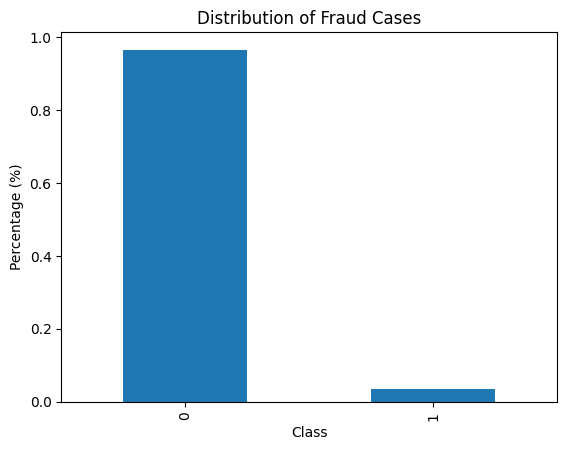

In [8]:
df["isFraud"].value_counts(normalize=True).plot.bar();

# label the chart
plt.title('Distribution of Fraud Cases')
plt.ylabel('Percentage (%)')
plt.xlabel('Class');

In [9]:
df.duplicated().sum()

np.int64(0)

Minimum transaction amount is: $0.251
Maximum transaction amount is: $31937.391
Average transaction amount is: $135.02717637247264
Median transaction amount is: $68.769


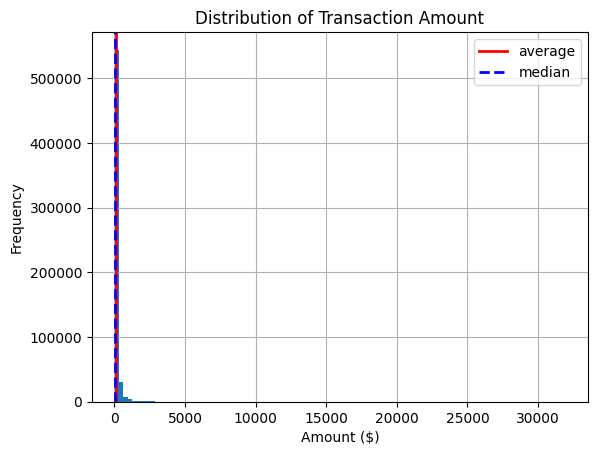

In [10]:
# Explore TransactionAmt

## calculate statistics
min = df['TransactionAmt'].min()
max = df['TransactionAmt'].max()
average = df['TransactionAmt'].mean()
median = df['TransactionAmt'].median()

print(f'Minimum transaction amount is: ${min}')
print(f'Maximum transaction amount is: ${max}')
print(f'Average transaction amount is: ${average}')
print(f'Median transaction amount is: ${median}')

# plot the statistics
df['TransactionAmt'].hist(bins = 100)
plt.axvline(average, color = 'r', linewidth = 2, label = 'average')
plt.axvline(median, color = 'b', linestyle = '--', linewidth = 2, label = 'median')

plt.title('Distribution of Transaction Amount')
plt.ylabel('Frequency')
plt.xlabel('Amount ($)')
plt.legend();

Clearly, the `transaction amount` distribution is skewed. We have majority of the amount is small and a few huge amounts. 
Also, some amounts have 3 decimal places which is not typical of currency. It can be due to currency convertion to dollar. We would investigate that later.

To investigate this further, let's plot a boxplot.

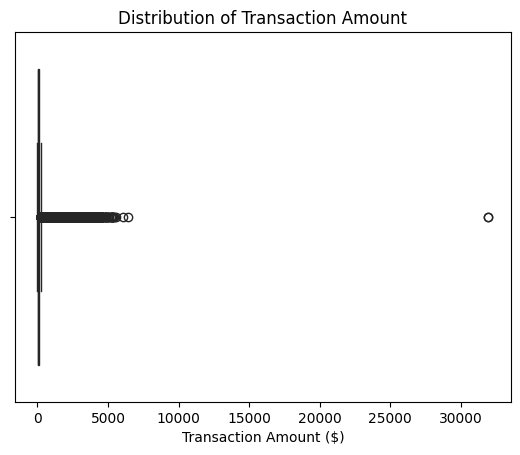

In [11]:
# Boxplot of Transaction amount
sns.boxplot(df['TransactionAmt'], orient = 'h', color = 'g')

# label the chart
plt.xlabel('Transaction Amount ($)')
plt.title('Distribution of Transaction Amount');

Clearly, we have can see the outlier. There's some few huge amounts around `$30,000`

In [12]:
# Investigate the top 10 largest values in TransactionAmount
df['TransactionAmt'].sort_values(ascending=False).head(10)

274339    31937.391
274336    31937.391
296021     6450.970
248413     6085.230
384603     5543.230
275529     5420.000
275535     5420.000
584767     5366.820
315172     5279.950
303106     5279.950
Name: TransactionAmt, dtype: float64

The unusually large transaction amounts observed in the dataset, while statistical outliers compared to the bulk of normal transactions, are not problematic in the context of fraud detection. Unlike in regression tasks where outliers can distort model performance, these high-value transactions may actually carry strong predictive signals, since fraudsters often attempt large purchases before detection. Therefore, rather than dropping them, it is better to retain these values and apply transformations such as log-scaling or robust scaling, ensuring the model can learn from these rare but important patterns without being skewed by their magnitude.

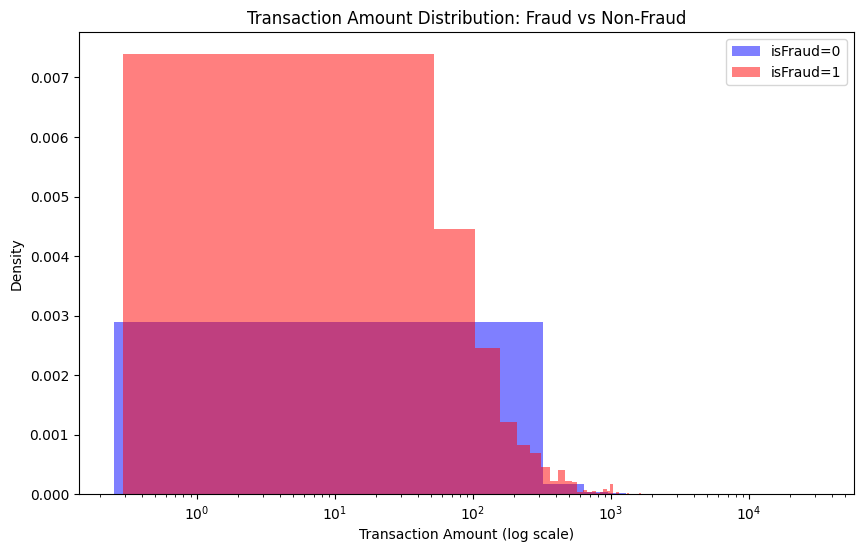

In [13]:
plt.figure(figsize=(10,6))

for label, color in zip([0, 1], ['blue', 'red']):
    subset = df[df['isFraud'] == label]['TransactionAmt']
    plt.hist(subset, bins=100, alpha=0.5, label=f'isFraud={label}', color=color, density=True)

plt.xscale('log')  # compresses large values
plt.xlabel("Transaction Amount (log scale)")
plt.ylabel("Density")
plt.title("Transaction Amount Distribution: Fraud vs Non-Fraud")
plt.legend()
plt.show()

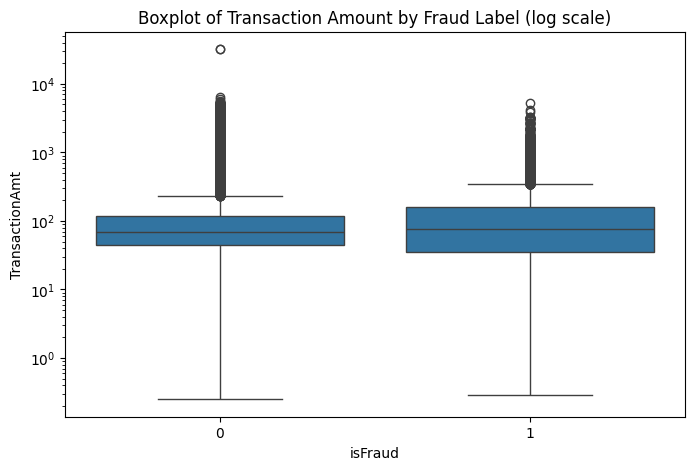

In [14]:
plt.figure(figsize=(8,5))
sns.boxplot(x='isFraud', y='TransactionAmt', data=df)
plt.yscale('log')
plt.title("Boxplot of Transaction Amount by Fraud Label (log scale)")
plt.show()

In [15]:
# Average amount per fraud label
df.groupby('isFraud')['TransactionAmt'].mean()

isFraud
0    134.511665
1    149.244779
Name: TransactionAmt, dtype: float64

In [16]:
# median amount per fraud label
df.groupby('isFraud')['TransactionAmt'].median()

isFraud
0    68.5
1    75.0
Name: TransactionAmt, dtype: float64

There's relatively similar values between fraud and normal transactions and it totally makes since to have a transaction amount of `$31k`. People can afford that.

In [17]:
# Check the missing values
df['TransactionAmt'].isnull().sum()

np.int64(0)

In [18]:
df[df['TransactionAmt'] % 0.001 != 0]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Round all amounts to 2 d.p.
df['TransactionAmt'] = df['TransactionAmt'].round(2)

In [20]:
df['TransactionAmt']

0          68.50
1          29.00
2          59.00
3          50.00
4          50.00
           ...  
590535     49.00
590536     39.50
590537     30.95
590538    117.00
590539    279.95
Name: TransactionAmt, Length: 590540, dtype: float64

In [21]:
# Explore TransactionDT
df['TransactionDT'].describe().apply(lambda x: f"{x:.0f}")

count      590540
mean      7372311
std       4617224
min         86400
25%       3027058
50%       7306528
75%      11246620
max      15811131
Name: TransactionDT, dtype: object

In [22]:
86400 / (24 * 60 * 60)

1.0

In [23]:
15811131 / (24 * 60 * 60)

182.99920138888888

In [24]:
183/30

6.1

Looking at the minimum and maximum values in `TransactionDT`, they're in seconds and span 6 months.

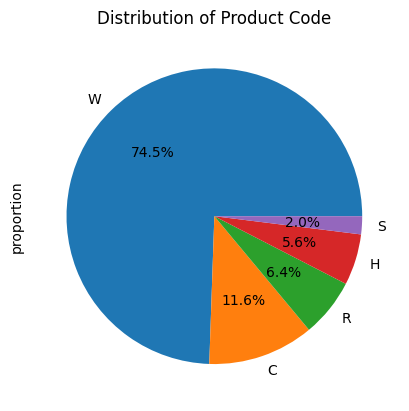

In [25]:
# Explore ProductCD
df['ProductCD'].value_counts(normalize = True).plot.pie(autopct='%1.1f%%')

plt.title('Distribution of Product Code');

In [26]:
df['ProductCD'].isna().sum()

np.int64(0)

In [27]:
# Explore the card details [card1 - card6]
card_cols = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']

df[card_cols].sample(10)

,card1,card2,card3,card4,card5,card6
539066,14712,111.0,150.0,visa,226.0,debit
354869,4663,490.0,150.0,visa,166.0,debit
81639,9026,545.0,185.0,visa,137.0,credit
547073,17188,321.0,150.0,visa,226.0,debit
524006,16489,546.0,147.0,mastercard,219.0,credit
248690,4504,500.0,185.0,mastercard,219.0,credit
299998,13530,455.0,150.0,mastercard,224.0,debit
370182,15528,111.0,150.0,visa,226.0,debit
39097,6457,321.0,150.0,visa,195.0,debit
139968,10557,555.0,231.0,visa,226.0,credit


In [28]:
df[card_cols].describe()

,card1,card2,card3,card5
count,590540.000000,581607.000000,588975.000000,586281.000000
mean,9898.734658,362.555488,153.194925,199.278897
std,4901.170153,157.793246,11.336444,41.244453
min,1000.000000,100.000000,100.000000,100.000000
25%,6019.000000,214.000000,150.000000,166.000000
50%,9678.000000,361.000000,150.000000,226.000000
75%,14184.000000,512.000000,150.000000,226.000000
max,18396.000000,600.000000,231.000000,237.000000


These card details will be important for analysis and later be tested for their importance is detecting fraud. Let's keep them.

In [29]:
# Explore addr1 and addr2
df[['addr1', 'addr2']].sample(5)

,addr1,addr2
227229,NaN,NaN
195958,NaN,NaN
273440,327.0,87.0
340004,272.0,87.0
195551,126.0,87.0


In [30]:
# Since addr2 is the billing country, let's explore the number of countries in there
df['addr2'].nunique()

74

In [31]:
print(df['addr2'].unique())

[ 87.  nan  96.  35.  60.  98.  43.  65.  32.  13.  31. 101.  24.  16.
  15.  19.  71.  59. 102.  44.  26.  69.  47.  78.  88.  66.  72.  22.
  57.  25.  17.  30.  29.  21.  14.  49.  83.  75.  34.  86.  48.  68.
  23.  70.  62.  54.  50.  52.  39.  76.  10.  73.  97.  63.  27.  28.
  38.  74.  77.  92.  79.  84.  82.  40.  36.  46.  18.  20.  89.  61.
  94. 100.  55.  51.  93.]


In [32]:
print(df['addr1'].unique())

[315. 325. 330. 476. 420. 272. 126. 337. 204.  nan 226. 170. 184. 264.
 299. 441. 472. 251. 469. 191. 485. 122. 220. 205. 387. 181. 231. 436.
 327. 343. 123. 502. 269. 158. 433. 143. 225. 492. 177. 512. 310. 308.
 418. 494. 253. 428. 203. 110. 444. 498. 194. 536. 384. 324. 295. 448.
 157. 171. 224. 491. 274. 432. 459. 106. 296. 254. 452. 347. 335. 305.
 161. 221. 154. 130. 465. 451. 331. 511. 486. 312. 242. 131. 508. 332.
 283. 216. 431. 391. 333. 496. 304. 167. 261. 399. 164. 142. 393. 258.
 375. 483. 404. 482. 148. 218. 127. 403. 374. 477. 478. 241. 504. 453.
 535. 100. 239. 152. 500. 356. 198. 162. 244. 520. 531. 401. 427. 352.
 540. 456. 371. 409. 529. 505. 503. 346. 359. 499. 298. 190. 454. 172.
 145. 493. 119. 521. 270. 395. 366. 348. 313. 338. 139. 443. 183. 430.
 102. 470. 133. 233. 468. 185. 523. 411. 501. 425. 426. 365. 129. 141.
 137. 249. 402. 386. 290. 111. 132. 278. 506. 128. 213. 514. 314. 445.
 252. 328. 210. 144. 193. 382. 306. 385. 235. 339. 211. 248. 163. 199.
 180. 

In [33]:
print(df[['addr1', 'addr2']].isna().sum())

print(f"addr1 has {round(df['addr1'].isna().sum() / df.shape[0] * 100, 2)}% missing values ")
print(f"addr2 has {round(df['addr2'].isna().sum() / df.shape[0] * 100, 2)}% missing values ")

addr1    65706
addr2    65706
dtype: int64
addr1 has 11.13% missing values 
addr2 has 11.13% missing values 


In [34]:
df[df['addr1'].isna() & df['isFraud'] == 1].shape

(7741, 394)

In [35]:
7741 / 65706 * 100

11.781268072930935

In [36]:
df[df['isFraud'] == 1].shape

(20663, 394)

In [37]:
7741 / 20663 * 100

37.463098291632384

In [38]:
df[df['addr2'].isna() & df['isFraud'] == 1].shape

(7741, 394)

The variables `addr1` and `addr2` contain a substantial proportion of missing values, with over `37%` occurring in fraud cases. Dropping these rows would result in significant loss of valuable fraud signals, so imputation is necessary. Since they are categorical features representing billing address, imputing with the mode is a baseline approach, but a better strategy is to treat missing values as a distinct category or include a missingness indicator feature. This preserves the strong predictive signal associated with missing addr1 entries, ensuring the model can leverage their relationship with fraudulent behavior.

In fraud detection, missingness itself can be informative. Fraudsters deliberately not providing billing info.

In [39]:
df.groupby(df['addr1'].isna())['isFraud'].mean()

addr1
False    0.024621
True     0.117813
Name: isFraud, dtype: float64

In [40]:
df.groupby(df['addr2'].isna())['isFraud'].mean()

addr2
False    0.024621
True     0.117813
Name: isFraud, dtype: float64

Analysis of `addr1` and `addr2` variables show that missing values are highly informative. Transactions without a billing region `(addr1, addr2 = NaN)` have an average fraud rate of `11.8%`, compared to only `2.5%` for those with valid values. This indicates that missingness in billing address is not random, but rather a strong predictor of fraud. Therefore, instead of dropping these records or imputing with the mode, it is more appropriate to treat missing values as a separate category or create a missingness indicator to preserve this valuable signal.

In [41]:
# Create a combined missingness flag
df['addr1_missing'] = df['addr1'].isna()
df['addr2_missing'] = df['addr2'].isna()

# Group by both conditions and check fraud rate + counts
result = df.groupby(['addr1_missing', 'addr2_missing'])['isFraud'].agg(['mean', 'count']).reset_index()

print(result)

   addr1_missing  addr2_missing      mean   count
0          False          False  0.024621  524834
1           True           True  0.117813   65706


Analysis shows that when both `addr1` and `addr2` are missing, the fraud rate rises to `~11.8%`, compared to `~2.5%` when both are present. This indicates that missingness in billing region data is not random but strongly associated with fraudulent activity. Therefore, instead of dropping or imputing with the mode, we will treat missing values as a special category to preserve this predictive signal.

In [42]:
# Count how many unique addr1 (regions) exist within each addr2 (country)
region_counts = df.groupby('addr2')['addr1'].nunique().reset_index()
region_counts.columns = ['addr2', 'unique_regions']
print(region_counts)

    addr2  unique_regions
0    10.0               1
1    13.0               3
2    14.0               1
3    15.0               1
4    16.0              17
..    ...             ...
69   97.0               1
70   98.0               2
71  100.0               1
72  101.0               4
73  102.0               4

[74 rows x 2 columns]


In [43]:
# Impute the missing values in billing address with special category
df['addr1'] = df['addr1'].fillna(-1).astype(int)
df['addr2'] = df['addr2'].fillna(-1).astype(int)

df[['addr1', 'addr2']].isna().sum()

addr1    0
addr2    0
dtype: int64

In [44]:
df['addr1'].unique()

array([315, 325, 330, 476, 420, 272, 126, 337, 204,  -1, 226, 170, 184,
       264, 299, 441, 472, 251, 469, 191, 485, 122, 220, 205, 387, 181,
       231, 436, 327, 343, 123, 502, 269, 158, 433, 143, 225, 492, 177,
       512, 310, 308, 418, 494, 253, 428, 203, 110, 444, 498, 194, 536,
       384, 324, 295, 448, 157, 171, 224, 491, 274, 432, 459, 106, 296,
       254, 452, 347, 335, 305, 161, 221, 154, 130, 465, 451, 331, 511,
       486, 312, 242, 131, 508, 332, 283, 216, 431, 391, 333, 496, 304,
       167, 261, 399, 164, 142, 393, 258, 375, 483, 404, 482, 148, 218,
       127, 403, 374, 477, 478, 241, 504, 453, 535, 100, 239, 152, 500,
       356, 198, 162, 244, 520, 531, 401, 427, 352, 540, 456, 371, 409,
       529, 505, 503, 346, 359, 499, 298, 190, 454, 172, 145, 493, 119,
       521, 270, 395, 366, 348, 313, 338, 139, 443, 183, 430, 102, 470,
       133, 233, 468, 185, 523, 411, 501, 425, 426, 365, 129, 141, 137,
       249, 402, 386, 290, 111, 132, 278, 506, 128, 213, 514, 31

In [45]:
# create a composite variable from the variables (combine them)
df['billing_address'] = df['addr1'].astype(str) + "_" + df['addr2'].astype(str)
df['billing_address'].sample(10)

387547    251_87
83622     387_87
468142    325_87
481631    310_87
258647    181_87
502872    327_87
282131    272_87
329156    251_87
576497    315_87
396918    264_87
Name: billing_address, dtype: object

In [46]:
# drop addr1 and addr2 missing columns
df.drop(columns = ['addr1_missing', 'addr2_missing'], axis=1, inplace=True)

In [47]:
# Explore the purchaser and recipient emails
df[['P_emaildomain', 'R_emaildomain']].describe()

,P_emaildomain,R_emaildomain
count,496084,137291
unique,59,60
top,gmail.com,gmail.com
freq,228355,57147


In [48]:
df[['P_emaildomain', 'R_emaildomain']].isna().sum()

P_emaildomain     94456
R_emaildomain    453249
dtype: int64

In [49]:
453249 / df.shape[0] * 100

76.75161716395164

Most transactions do not require recipient address so over `76%` of it is missing. It needs to be dropped.

In [50]:
# drop R_emaildomain
df.drop(columns='R_emaildomain', axis = 1, inplace = True)
print('Variable successfully dropped')

Variable successfully dropped


In [51]:
n_email = df['P_emaildomain'].nunique()
emails = df['P_emaildomain'].unique()

print(f"There are {n_email} unique email domain and they're: \n {emails}")

There are 59 unique email domain and they're: 
 [nan 'gmail.com' 'outlook.com' 'yahoo.com' 'mail.com' 'anonymous.com'
 'hotmail.com' 'verizon.net' 'aol.com' 'me.com' 'comcast.net'
 'optonline.net' 'cox.net' 'charter.net' 'rocketmail.com' 'prodigy.net.mx'
 'embarqmail.com' 'icloud.com' 'live.com.mx' 'gmail' 'live.com' 'att.net'
 'juno.com' 'ymail.com' 'sbcglobal.net' 'bellsouth.net' 'msn.com' 'q.com'
 'yahoo.com.mx' 'centurylink.net' 'servicios-ta.com' 'earthlink.net'
 'hotmail.es' 'cfl.rr.com' 'roadrunner.com' 'netzero.net' 'gmx.de'
 'suddenlink.net' 'frontiernet.net' 'windstream.net' 'frontier.com'
 'outlook.es' 'mac.com' 'netzero.com' 'aim.com' 'web.de' 'twc.com'
 'cableone.net' 'yahoo.fr' 'yahoo.de' 'yahoo.es' 'sc.rr.com' 'ptd.net'
 'live.fr' 'yahoo.co.uk' 'hotmail.fr' 'hotmail.de' 'hotmail.co.uk'
 'protonmail.com' 'yahoo.co.jp']


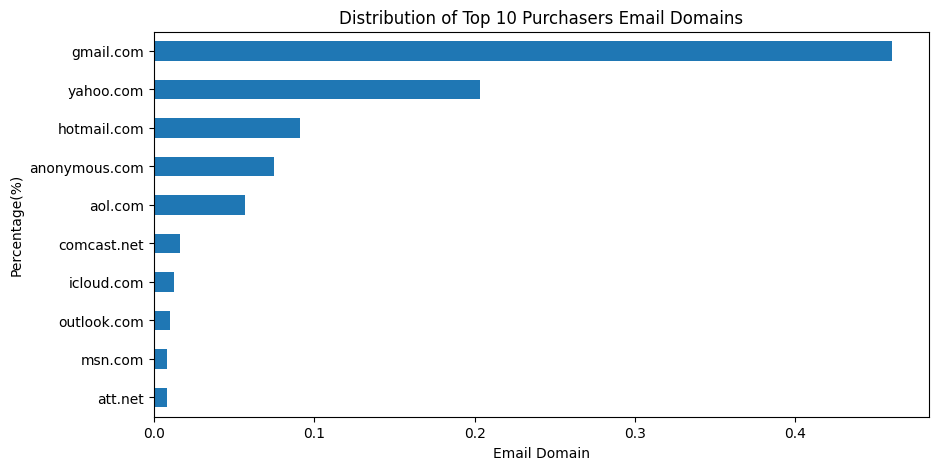

In [52]:
# Explore the top 10 email domains
df['P_emaildomain'].value_counts(normalize=True).head(10).sort_values().plot.barh(figsize=(10,5))

# label the chart
plt.title('Distribution of Top 10 Purchasers Email Domains')
plt.ylabel('Percentage(%)')
plt.xlabel('Email Domain');

In [53]:
df['P_emaildomain'].value_counts(normalize=True).sort_values(ascending=False).head(10)

P_emaildomain
gmail.com        0.460315
yahoo.com        0.203462
hotmail.com      0.091214
anonymous.com    0.074580
aol.com          0.057025
comcast.net      0.015901
icloud.com       0.012633
outlook.com      0.010272
msn.com          0.008249
att.net          0.008130
Name: proportion, dtype: float64

In [54]:
df.groupby(df['P_emaildomain'].isna())['isFraud'].mean()

P_emaildomain
False    0.036028
True     0.029538
Name: isFraud, dtype: float64

In [55]:
# Impute missing Email Domains with the mode
mode = df['P_emaildomain'].mode()[0]

df['P_emaildomain'] = df['P_emaildomain'].fillna(mode)
df['P_emaildomain'].isna().sum()

np.int64(0)

In [56]:
df.groupby('P_emaildomain')['isFraud'].agg(['mean', 'count']).sort_values('mean', ascending=False).head(10)

,mean,count
P_emaildomain,,
protonmail.com,0.407895,76
mail.com,0.189624,559
outlook.es,0.130137,438
aim.com,0.126984,315
outlook.com,0.094584,5096
hotmail.es,0.065574,305
live.com.mx,0.054740,749
hotmail.com,0.052950,45250
gmail.com,0.039444,322811


The analysis of `P_emaildomain` shows clear differences in fraud prevalence across email providers. Fraud rates are highest for less common domains such as `protonmail.com (40.8%)`, `mail.com (18.9%)`, and `outlook.es (13.0%)`. In contrast, widely used domains such as `gmail.com (3.9%)`, `hotmail.com (5.3%)`, and `yahoo.fr (3.5%)` exhibit substantially lower fraud rates despite having large transaction volumes. This trend may be explained by several factors: niche or privacy-focused providers (e.g., ProtonMail) attract fraudsters because they allow greater anonymity, smaller providers often have weaker security and monitoring systems, and unusual domains can make it harder to trace fraudulent accounts. On the other hand, mainstream providers such as Gmail, Hotmail, and Yahoo employ stricter verification, stronger fraud detection, and benefit from their large user bases where fraud attempts are diluted. These findings suggest that email domain choice itself may be a valuable risk indicator in fraud detection.

To strengthen the predictive power of the P_emaildomain feature while ensuring stability in production, we engineered three new categorical variables: provider_bucket, suffix_bucket, and fraud_bucket. The provider and suffix were extracted separately to capture both email service type (e.g., Gmail, Outlook, Yahoo) and regional domain extensions (e.g., .es, .fr, .mx), as these can carry distinct fraud risks. Popular domains such as Gmail, Yahoo, and Hotmail were retained individually due to their large transaction volumes, while infrequent providers and suffixes were grouped into a "rare" category to avoid noise. Fraud rates per domain were also analyzed, and each domain was assigned to a fraud risk bucket (high, medium, low, or rare) based on observed fraud prevalence and support size. This approach balances signal extraction with robustness, ensuring that the model captures meaningful fraud patterns from both provider reputation and regional tendencies without overfitting to small, unstable categories.

In [57]:
# ---Split provider and suffix ---
df['P_emaildomain'] = df['P_emaildomain'].fillna('missing')
df['provider'] = df['P_emaildomain'].apply(lambda x: x.split('.')[0] if x != 'missing' else 'missing')
df['suffix'] = df['P_emaildomain'].apply(lambda x: x.split('.')[-1] if x != 'missing' else 'missing')

df[['P_emaildomain', 'provider', 'suffix']].sample(10)

,P_emaildomain,provider,suffix
31857,gmail.com,gmail,com
216335,optonline.net,optonline,net
169426,yahoo.com,yahoo,com
147731,gmail.com,gmail,com
239419,gmail.com,gmail,com
359842,gmail.com,gmail,com
578742,gmail.com,gmail,com
420376,aol.com,aol,com
2733,gmail.com,gmail,com
139024,gmail.com,gmail,com


In [58]:
# --- Bucket rare providers ---
provider_counts = df['provider'].value_counts()
rare_threshold = 500
df['provider_bucket'] = df['provider'].apply(lambda x: x if provider_counts[x] >= rare_threshold else 'rare')
df['provider_bucket'].sample(20)

416646      comcast
14806           aol
4802         icloud
170838      outlook
364636        yahoo
297096        gmail
330117        gmail
353597    anonymous
153580        gmail
302381        yahoo
369124      outlook
266101        gmail
442062        yahoo
452972       icloud
94811     anonymous
584532        gmail
294672        gmail
212421          aol
227301        gmail
542236        gmail
Name: provider_bucket, dtype: object

In [59]:
df['provider_bucket'].unique()

array(['gmail', 'outlook', 'yahoo', 'mail', 'anonymous', 'hotmail',
       'verizon', 'aol', 'me', 'comcast', 'optonline', 'cox', 'charter',
       'rocketmail', 'rare', 'icloud', 'live', 'att', 'ymail',
       'sbcglobal', 'bellsouth', 'msn', 'earthlink'], dtype=object)

In [60]:
# --- Fraud rate per domain ---
fraud_stats = df.groupby('P_emaildomain')['isFraud'].agg(['mean','count']).reset_index()
fraud_stats

def fraud_bucket(row):
    if row['count'] < 100:
        return 'rare'
    elif row['mean'] >= 0.10:
        return 'high'
    elif row['mean'] >= 0.03:
        return 'medium'
    else:
        return 'low'

fraud_stats['fraud_bucket'] = fraud_stats.apply(fraud_bucket, axis=1)

In [61]:
# Map fraud bucket back to df
fraud_map = fraud_stats.set_index('P_emaildomain')['fraud_bucket'].to_dict()
df['fraud_bucket'] = df['P_emaildomain'].map(fraud_map).fillna('rare')

df['fraud_bucket'].sample(20)

204974    medium
247768    medium
357736    medium
242984       low
321567    medium
227284       low
259633    medium
299207    medium
543090       low
46008        low
580868    medium
261026    medium
171505    medium
273533       low
553844    medium
253296       low
449778       low
28705        low
17992        low
411288    medium
Name: fraud_bucket, dtype: object

In [62]:
print(fraud_stats['fraud_bucket'])

0       high
1        low
2        low
3        low
4        low
5        low
6        low
7        low
8     medium
9     medium
10       low
11       low
12    medium
13       low
14       low
15       low
16    medium
17       low
18       low
19    medium
20      rare
21    medium
22       low
23    medium
24       low
25       low
26    medium
27      rare
28    medium
29      high
30       low
31       low
32       low
33       low
34       low
35    medium
36      high
37       low
38      rare
39      rare
40       low
41       low
42       low
43       low
44       low
45      rare
46       low
47       low
48       low
49       low
50       low
51      rare
52      rare
53       low
54       low
55      rare
56       low
57    medium
58       low
Name: fraud_bucket, dtype: object


In [63]:
# --- Handle suffix ---
suffix_counts = df['suffix'].value_counts()
suffix_threshold = 200
df['suffix_bucket'] = df['suffix'].apply(lambda x: x if suffix_counts[x] >= suffix_threshold else 'rare')

df['suffix_bucket'].sample(20)

9439      com
225551    com
55835     net
364181    com
204701    com
377691    com
420402    com
61263     com
152390    com
370290    com
333643    com
161207    com
458672    com
304650    com
134706    com
473742    com
477936    com
470804    com
385240    com
338597    com
Name: suffix_bucket, dtype: object

In [64]:
df['suffix_bucket'].unique()

array(['com', 'net', 'mx', 'gmail', 'es', 'de', 'fr', 'rare'],
      dtype=object)

In [65]:
df['provider_bucket'].unique()

array(['gmail', 'outlook', 'yahoo', 'mail', 'anonymous', 'hotmail',
       'verizon', 'aol', 'me', 'comcast', 'optonline', 'cox', 'charter',
       'rocketmail', 'rare', 'icloud', 'live', 'att', 'ymail',
       'sbcglobal', 'bellsouth', 'msn', 'earthlink'], dtype=object)

In [66]:
# Now drop P_emaildomain
df.drop(columns = 'P_emaildomain', axis = 1, inplace = True)

In [67]:
# Explore C1 - C14
c_cols = []
for i in range(1, 15):
    v = 'C' + str(i)
    c_cols.append(v)
print(c_cols)

['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']


In [68]:
df[c_cols].sample(10)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
445769,1.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,20.0,1.0
449016,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
188581,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
202660,1.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,11.0,1.0
25890,1.0,2.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,2.0,1.0,0.0,2.0,1.0
336978,2.0,2.0,0.0,0.0,1.0,3.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,2.0
49137,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
523506,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,5.0,1.0
268709,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
80658,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


In [69]:
df[c_cols].isna().sum()

C1     0
C2     0
C3     0
C4     0
C5     0
C6     0
C7     0
C8     0
C9     0
C10    0
C11    0
C12    0
C13    0
C14    0
dtype: int64

My goal is to build an explanable model. So, I'll only be using variables I have much information about and understand. There's limited info about these in the data description. Hence, i'll not include them.

In [70]:
# Drop C1 - C4
df.drop(columns = c_cols, axis = 1, inplace = True)

In [71]:
df.shape

(590540, 384)

In [72]:
# Explore M1 - M9
m_cols = []
for i in range(1, 10):
    v = 'M' + str(i)
    m_cols.append(v)
print(m_cols)

['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']


In [73]:
df[m_cols].sample(10)

,M1,M2,M3,M4,M5,M6,M7,M8,M9
409916,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
542850,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
310563,NaN,NaN,NaN,M1,T,F,NaN,NaN,NaN
258217,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
583908,T,T,T,M0,F,F,F,T,T
36101,NaN,NaN,NaN,M0,F,F,NaN,NaN,NaN
369669,T,T,F,M0,T,T,F,T,T
132651,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
241744,T,T,T,M0,T,T,F,T,T
159694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
df[m_cols].isna().sum()

M1    271100
M2    271100
M3    271100
M4    281444
M5    350482
M6    169360
M7    346265
M8    346252
M9    346252
dtype: int64

In [75]:
# Drop M1 - M9
df.drop(columns = m_cols, axis = 1, inplace = True)

In [76]:
df.shape

(590540, 375)

In [77]:
print(df.columns.to_list())

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106

In [78]:
# Explore V1 - V339
v_cols = []
for i in range(1, 340):
    v = 'V' + str(i)
    v_cols.append(v)
print(v_cols)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V1

In [79]:
df[v_cols].isna().sum()

V1      279287
V2      279287
V3      279287
V4      279287
V5      279287
         ...  
V335    508189
V336    508189
V337    508189
V338    508189
V339    508189
Length: 339, dtype: int64

In [80]:
279287 / df.shape[0] * 100

47.29349409015477

There's not much information about these variables. Their real meanings are masked. Again, they have more missing values.

In [81]:
# drop V1 - V339
df.drop(columns = v_cols, axis = 1, inplace = True)

In [82]:
df.shape

(590540, 36)

In [83]:
df.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6',
       'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15',
       'billing_address', 'provider', 'suffix', 'provider_bucket',
       'fraud_bucket', 'suffix_bucket'],
      dtype='object')

In [84]:
df.isna().sum()

TransactionID           0
isFraud                 0
TransactionDT           0
TransactionAmt          0
ProductCD               0
card1                   0
card2                8933
card3                1565
card4                1577
card5                4259
card6                1571
addr1                   0
addr2                   0
dist1              352271
dist2              552913
D1                   1269
D2                 280797
D3                 262878
D4                 168922
D5                 309841
D6                 517353
D7                 551623
D8                 515614
D9                 515614
D10                 76022
D11                279287
D12                525823
D13                528588
D14                528353
D15                 89113
billing_address         0
provider                0
suffix                  0
provider_bucket         0
fraud_bucket            0
suffix_bucket           0
dtype: int64

In [85]:
df['suffix'].head()

0    com
1    com
2    com
3    com
4    com
Name: suffix, dtype: object

In [86]:
df['suffix_bucket'].head()

0    com
1    com
2    com
3    com
4    com
Name: suffix_bucket, dtype: object

In [87]:
df[['suffix_bucket', 'suffix']].tail(15)

,suffix_bucket,suffix
590525,com,com
590526,com,com
590527,com,com
590528,com,com
590529,com,com
590530,com,com
590531,com,com
590532,net,net
590533,com,com
590534,com,com


In [88]:
cols = ['suffix', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14']

In [89]:
# Drop variables with high missing values and less relevant (duplicates, leakages, etc)
df.drop(columns = cols, axis = 1, inplace = True)

df.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10',
       'D11', 'D15', 'billing_address', 'provider', 'provider_bucket',
       'fraud_bucket', 'suffix_bucket'],
      dtype='object')

In [90]:
df.isna().sum()

TransactionID           0
isFraud                 0
TransactionDT           0
TransactionAmt          0
ProductCD               0
card1                   0
card2                8933
card3                1565
card4                1577
card5                4259
card6                1571
addr1                   0
addr2                   0
dist1              352271
dist2              552913
D1                   1269
D2                 280797
D3                 262878
D4                 168922
D5                 309841
D10                 76022
D11                279287
D15                 89113
billing_address         0
provider                0
provider_bucket         0
fraud_bucket            0
suffix_bucket           0
dtype: int64

In [91]:
df[['card1', 'card2', 'card3', 'card4', 'card5', 'card6']].head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


In [92]:
# Investigate the missing values in each card variable
### card2
df.groupby(df['card2'].isna())['isFraud'].mean()

card2
False    0.034800
True     0.047353
Name: isFraud, dtype: float64

In [93]:
### card3
df.groupby(df['card3'].isna())['isFraud'].mean()

card3
False    0.035017
True     0.024920
Name: isFraud, dtype: float64

In [94]:
### card4
df.groupby(df['card4'].isna())['isFraud'].mean()

card4
False    0.035014
True     0.025999
Name: isFraud, dtype: float64

In [95]:
### card5
df.groupby(df['card5'].isna())['isFraud'].mean()

card5
False    0.034886
True     0.049307
Name: isFraud, dtype: float64

In [96]:
### card6
df.groupby(df['card6'].isna())['isFraud'].mean()

card6
False    0.035017
True     0.024825
Name: isFraud, dtype: float64

For the card features, we investigated whether missingness itself carried predictive power by comparing fraud rates between missing and non-missing values. \
We found that for card2 and card5, missing values were associated with higher fraud rates, while for card3, card4, and card6, missingness corresponded to lower fraud rates. \
Since this indicates that missingness is not random but informative, we represent missing values with a distinct `"missing"` category rather than imputing with the mode. \
This approach preserves the fraud-related signal in the data and allows the model to leverage missingness as an additional predictive feature.

In [97]:
# List of card features to transform
card_features = ['card2', 'card3', 'card4', 'card5', 'card6']

# Replace NaNs with string 'missing'
for col in card_features:
    df[col] = df[col].fillna("missing").astype(str)

df.isna().sum()

TransactionID           0
isFraud                 0
TransactionDT           0
TransactionAmt          0
ProductCD               0
card1                   0
card2                   0
card3                   0
card4                   0
card5                   0
card6                   0
addr1                   0
addr2                   0
dist1              352271
dist2              552913
D1                   1269
D2                 280797
D3                 262878
D4                 168922
D5                 309841
D10                 76022
D11                279287
D15                 89113
billing_address         0
provider                0
provider_bucket         0
fraud_bucket            0
suffix_bucket           0
dtype: int64

In [98]:
# Investigate the missing values in each distance variable
### dist1
df.groupby(df['dist1'].isna())['isFraud'].mean()

dist1
False    0.019956
True     0.045158
Name: isFraud, dtype: float64

In [99]:
### dist2
df.groupby(df['dist2'].isna())['isFraud'].mean()

dist2
False    0.099158
True     0.030623
Name: isFraud, dtype: float64

In analyzing the distance variables, we investigated whether missingness itself carried a fraud signal by comparing average fraud rates between transactions with present values and those with missing values.\
For `dist1`, the fraud rate more than doubled when the value was missing (4.5% vs. 2.0%), while for `dist2`, fraud was substantially higher when the value was present (9.9% vs. 3.1% when missing). \
This indicates that missingness is not random but correlated with fraudulent behavior. \
Based on this, we will retain both features and explicitly encode missingness—either by introducing a `"missing"` category or by using sentinel values with a missing indicator flag—so that the model can leverage the predictive power of incomplete distance information.

In [100]:
distance_features = ['dist1', 'dist2']

for col in distance_features:
    df[col] = df[col].fillna("missing").astype(str)

df.isna().sum()

TransactionID           0
isFraud                 0
TransactionDT           0
TransactionAmt          0
ProductCD               0
card1                   0
card2                   0
card3                   0
card4                   0
card5                   0
card6                   0
addr1                   0
addr2                   0
dist1                   0
dist2                   0
D1                   1269
D2                 280797
D3                 262878
D4                 168922
D5                 309841
D10                 76022
D11                279287
D15                 89113
billing_address         0
provider                0
provider_bucket         0
fraud_bucket            0
suffix_bucket           0
dtype: int64

In [101]:
# Investigate the time features
## D1
df.groupby(df['D1'].isna())['isFraud'].mean()

D1
False    0.034987
True     0.036249
Name: isFraud, dtype: float64

In [102]:
## D2
df.groupby(df['D2'].isna())['isFraud'].mean()

D2
False    0.025408
True     0.045560
Name: isFraud, dtype: float64

In [103]:
## D3
df.groupby(df['D3'].isna())['isFraud'].mean()

D3
False    0.029356
True     0.042012
Name: isFraud, dtype: float64

In [104]:
## D4
df.groupby(df['D4'].isna())['isFraud'].mean()

D4
False    0.034550
True     0.036088
Name: isFraud, dtype: float64

In [105]:
## D5
df.groupby(df['D5'].isna())['isFraud'].mean()

D5
False    0.038760
True     0.031574
Name: isFraud, dtype: float64

In [106]:
## D10
df.groupby(df['D10'].isna())['isFraud'].mean()

D10
False    0.032607
True     0.051117
Name: isFraud, dtype: float64

In [107]:
## D11
df.groupby(df['D11'].isna())['isFraud'].mean()

D11
False    0.019617
True     0.052122
Name: isFraud, dtype: float64

In [108]:
## D15
df.groupby(df['D15'].isna())['isFraud'].mean()

D15
False    0.032681
True     0.047984
Name: isFraud, dtype: float64

For the time-delta variables `(D1–D15)`, we examined whether missing values correlated with fraudulent activity. The results showed that for most features—including `D2, D3, D5, D10, D11, and D15`—fraud rates were significantly different when values were missing compared to when they were present, indicating that missingness itself carries predictive value. In contrast, D1 and D4 showed little difference, suggesting that their missingness is less informative. To capture these patterns, we will impute D1 and D4 using their median values, while for the others we will use a sentinel value `(−1)` combined with a binary missingness indicator. This approach preserves the numeric nature of the features while ensuring the model can leverage missingness as a fraud signal.

In [109]:
D_features = ['D1','D2','D3','D4','D5','D10','D11','D15']

for col in D_features:
    
    if col in ['D1','D4']:
        # Missingness not predictive → median imputation
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
    else:
        # Missingness predictive → sentinel value (-1)
        df[col] = df[col].fillna(-1)


In [110]:
time_features = ['D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15']

In [111]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,D4,D5,D10,D11,D15,billing_address,provider,provider_bucket,fraud_bucket,suffix_bucket
0,2987000,0,86400,68.5,W,13926,missing,150.0,discover,142.0,...,26.0,-1.0,13.0,13.0,0.0,315_87,gmail,gmail,medium,com
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0.0,-1.0,0.0,-1.0,0.0,325_87,gmail,gmail,medium,com
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,0.0,-1.0,0.0,315.0,315.0,330_87,outlook,outlook,medium,com
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,94.0,0.0,84.0,-1.0,111.0,476_87,yahoo,yahoo,low,com
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,26.0,-1.0,-1.0,-1.0,-1.0,420_87,gmail,gmail,medium,com


In [112]:
df.isna().sum()

TransactionID      0
isFraud            0
TransactionDT      0
TransactionAmt     0
ProductCD          0
card1              0
card2              0
card3              0
card4              0
card5              0
card6              0
addr1              0
addr2              0
dist1              0
dist2              0
D1                 0
D2                 0
D3                 0
D4                 0
D5                 0
D10                0
D11                0
D15                0
billing_address    0
provider           0
provider_bucket    0
fraud_bucket       0
suffix_bucket      0
dtype: int64

In [113]:
df[['provider', 'provider_bucket']].sample(10)

,provider,provider_bucket
75420,anonymous,anonymous
563763,gmail,gmail
1205,verizon,verizon
125070,gmail,gmail
76902,gmail,gmail
158416,gmail,gmail
154998,me,me
216267,gmail,gmail
315126,gmail,gmail
40135,anonymous,anonymous


In [114]:
# Drop the provider feature -> same as provider bucket
df.drop(columns = 'provider', axis = 1, inplace = True)
df.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10',
       'D11', 'D15', 'billing_address', 'provider_bucket', 'fraud_bucket',
       'suffix_bucket'],
      dtype='object')

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 27 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TransactionID    590540 non-null  int64  
 1   isFraud          590540 non-null  int64  
 2   TransactionDT    590540 non-null  int64  
 3   TransactionAmt   590540 non-null  float64
 4   ProductCD        590540 non-null  object 
 5   card1            590540 non-null  int64  
 6   card2            590540 non-null  object 
 7   card3            590540 non-null  object 
 8   card4            590540 non-null  object 
 9   card5            590540 non-null  object 
 10  card6            590540 non-null  object 
 11  addr1            590540 non-null  int64  
 12  addr2            590540 non-null  int64  
 13  dist1            590540 non-null  object 
 14  dist2            590540 non-null  object 
 15  D1               590540 non-null  float64
 16  D2               590540 non-null  floa

# Now Explore and Clean the Identity dataset

In [116]:
df_identity = pd.read_csv('dataset/train_identity.csv')

print(f"Dataset shape: {df_identity.shape}")

Dataset shape: (144233, 41)


In [117]:
df_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [118]:
# check for duplicates in dataset
df_identity['TransactionID'].duplicated().sum()

np.int64(0)

In [119]:
df_identity.duplicated().sum()

np.int64(0)

In [120]:
# Check for missing values in the dataset
df_identity.isna().sum()

TransactionID         0
id_01                 0
id_02              3361
id_03             77909
id_04             77909
id_05              7368
id_06              7368
id_07            139078
id_08            139078
id_09             69307
id_10             69307
id_11              3255
id_12                 0
id_13             16913
id_14             64189
id_15              3248
id_16             14893
id_17              4864
id_18             99120
id_19              4915
id_20              4972
id_21            139074
id_22            139064
id_23            139064
id_24            139486
id_25            139101
id_26            139070
id_27            139064
id_28              3255
id_29              3255
id_30             66668
id_31              3951
id_32             66647
id_33             70944
id_34             66428
id_35              3248
id_36              3248
id_37              3248
id_38              3248
DeviceType         3423
DeviceInfo        25567
dtype: int64

In [121]:
# Drop features with too much missing values
drop_cols = ['id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']

df_identity.drop(columns = drop_cols, axis = 1, inplace = True)
df_identity.isna().sum()

TransactionID        0
id_01                0
id_02             3361
id_03            77909
id_04            77909
id_05             7368
id_06             7368
id_09            69307
id_10            69307
id_11             3255
id_12                0
id_13            16913
id_14            64189
id_15             3248
id_16            14893
id_17             4864
id_18            99120
id_19             4915
id_20             4972
id_28             3255
id_29             3255
id_30            66668
id_31             3951
id_32            66647
id_33            70944
id_34            66428
id_35             3248
id_36             3248
id_37             3248
id_38             3248
DeviceType        3423
DeviceInfo       25567
dtype: int64

In [122]:
df_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 32 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_09          74926 non-null   float64
 8   id_10          74926 non-null   float64
 9   id_11          140978 non-null  float64
 10  id_12          144233 non-null  object 
 11  id_13          127320 non-null  float64
 12  id_14          80044 non-null   float64
 13  id_15          140985 non-null  object 
 14  id_16          129340 non-null  object 
 15  id_17          139369 non-null  float64
 16  id_18          45113 non-null   float64
 17  id_19          139318 non-nul

****************************************
Number of unique values: 2
Unique values: ['mobile' 'desktop' nan]
****************************************
DeviceType
desktop    60.48
mobile     39.52
Name: proportion, dtype: float64
****************************************


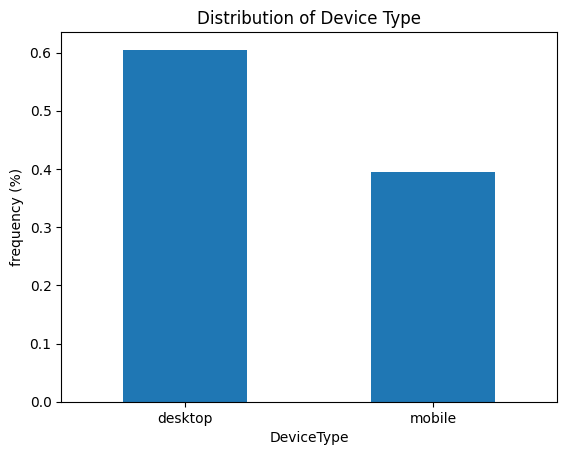

In [123]:
# Explore the device types used
print('*' * 40)
print('Number of unique values:', df_identity['DeviceType'].nunique())
print('Unique values:', df_identity['DeviceType'].unique())

dist = df_identity['DeviceType'].value_counts(normalize=True)

print('*' * 40)
print(round(dist * 100, 2))
print('*' * 40)

# plot the distribution
dist.plot.bar()
# label the chart
plt.ylabel('frequency (%)')
plt.title('Distribution of Device Type')

# rotate the x-axis labels
plt.xticks(rotation = 0);

In [124]:
# percentage of missing values in device type feature
print(f"There is {round(df_identity['DeviceType'].isna().sum() / df_identity.shape[0] * 100, 2)}% of missing values")

There is 2.37% of missing values


Before deciding on the imputation strategy for `DeviceType`, it is good to first check how missingness impacts fraud. So, there's the need to merge the two datasets and explore this

The identity dataset contains system-captured digital fingerprints such as device type, browser, and network information. Unlike user-entered data, these fields are automatically recorded by fraud detection systems whenever signals are available. This makes missing values highly meaningful: they are not random accidents, but rather the absence of traceable identity information.

For fraud detection, this is critical because sophisticated criminals often take deliberate steps to mask or manipulate their digital fingerprints (using proxies, VPNs, emulators, or anonymized browsers). As a result, the presence or absence of identity data can itself be a strong predictor of fraud. By investigating missingness, we can uncover whether certain gaps in the identity dataset are correlated with fraudulent activity — turning what looks like “incomplete data” into a valuable risk indicator.

In [125]:
# Check for the coverage of transaction ids in the identity dataset (transactions in both dataset)

common_ids = set(df['TransactionID']).intersection(df_identity['TransactionID'])
print("Overlap:", len(common_ids))
print("Coverage:", len(common_ids) / df['TransactionID'].nunique())  # ~24%

Overlap: 144233
Coverage: 0.2442391709283029


In [126]:
# merge the 2 datasets
df_merged = df.merge(df_identity, on = 'TransactionID', how = 'left')

df_merged.shape

(590540, 58)

In [127]:
print(df_merged.columns)

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10',
       'D11', 'D15', 'billing_address', 'provider_bucket', 'fraud_bucket',
       'suffix_bucket', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_28', 'id_29', 'id_30', 'id_31',
       'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')


In [128]:
df_merged.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,missing,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [129]:
df_merged.groupby(df_merged['DeviceType'].isna())['isFraud'].mean()

DeviceType
False    0.079618
True     0.021017
Name: isFraud, dtype: float64

Analysis shows that transactions with missing `DeviceType` information have a substantially lower fraud rate `(~2.1%)` compared to those where the device type is known `(~8.0%)`. This indicates that missingness itself carries predictive value. Instead of imputing these missing values, we should treat them as a distinct `"unknown"` category so the model can capture this signal.

In [130]:
# Impute missing values in device type feature
df_identity['DeviceType'] = df_identity['DeviceType'].fillna('unknown')
df_identity['DeviceType'].isna().sum()

np.int64(0)

**********************************************************************
Missing values: 25567
Number of unique values: 1786
Unique values: ['SAMSUNG SM-G892A Build/NRD90M' 'iOS Device' 'Windows' ...
 'LDN-LX3 Build/HUAWEILDN-LX3' 'Z955A' 'LG-E975']
**********************************************************************


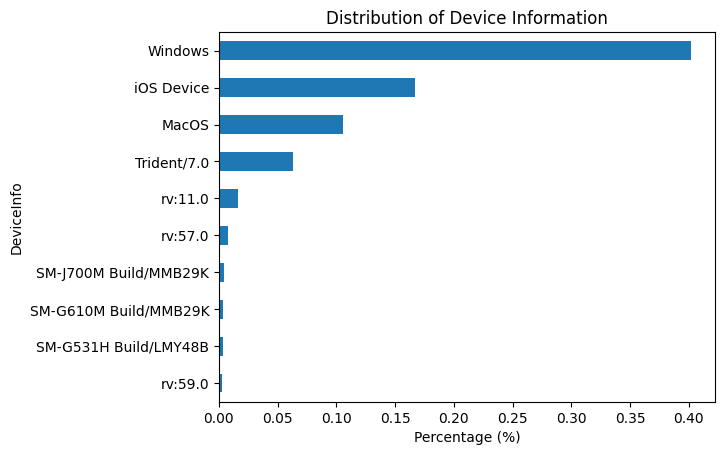

In [131]:
# Investigate `DeviceInfo` feature
print('*' * 70)
print('Missing values:', df_identity['DeviceInfo'].isna().sum())
print('Number of unique values:', df_identity['DeviceInfo'].nunique())
print('Unique values:', df_identity['DeviceInfo'].unique())
print('*' * 70)

# plot the top 10
df_identity['DeviceInfo'].value_counts(normalize=True).head(10).sort_values().plot.barh()

# label the chart
plt.xlabel('Percentage (%)')
plt.title('Distribution of Device Information');

In [132]:
df_identity['DeviceInfo'].value_counts().head(50)

DeviceInfo
Windows                                47722
iOS Device                             19782
MacOS                                  12573
Trident/7.0                             7440
rv:11.0                                 1901
rv:57.0                                  962
SM-J700M Build/MMB29K                    549
SM-G610M Build/MMB29K                    461
SM-G531H Build/LMY48B                    410
rv:59.0                                  362
SM-G935F Build/NRD90M                    334
SM-G955U Build/NRD90M                    328
SM-G532M Build/MMB29T                    316
ALE-L23 Build/HuaweiALE-L23              312
SM-G950U Build/NRD90M                    290
SM-G930V Build/NRD90M                    274
rv:58.0                                  269
rv:52.0                                  256
SAMSUNG                                  235
SM-G950F Build/NRD90M                    225
Moto G (4) Build/NPJ25.93-14.7           219
SM-N950U Build/NMF26X                    209

In [133]:
# Categorize all other device info as 'others' for ease identification and reduce dimensionality

## set threshold
threshold = 200

## find frequent categories
device_counts = df_identity['DeviceInfo'].value_counts()
frequent_devices = device_counts[device_counts >= threshold].index

## replace rare ones with 'others'
df_identity['DeviceInfo'] = df_identity['DeviceInfo'].apply(
    lambda x: x if x in frequent_devices else 'others'
)

## fill missing values with 'unknown'
df_identity['DeviceInfo'] = df_identity['DeviceInfo'].fillna('unknown')

print('Number of missing values:', df_identity['DeviceInfo'].isna().sum())
print(df_identity['DeviceInfo'].unique())

Number of missing values: 0
['others' 'iOS Device' 'Windows' 'MacOS' 'SM-G930V Build/NRD90M' 'rv:52.0'
 'SM-G950U Build/NRD90M' 'SM-J700M Build/MMB29K' 'Trident/7.0' 'rv:57.0'
 'SM-G955U Build/NRD90M' 'SM-G610M Build/MMB29K' 'SAMSUNG' 'rv:11.0'
 'SM-G531H Build/LMY48B' 'SM-G935F Build/NRD90M'
 'ALE-L23 Build/HuaweiALE-L23' 'SM-G950F Build/NRD90M'
 'SM-N950U Build/NMF26X' 'SM-A300H Build/LRX22G' 'SM-G532M Build/MMB29T'
 'Moto G (4) Build/NPJ25.93-14.7' 'rv:58.0' 'rv:59.0']


In [134]:
df_identity.isna().sum()

TransactionID        0
id_01                0
id_02             3361
id_03            77909
id_04            77909
id_05             7368
id_06             7368
id_09            69307
id_10            69307
id_11             3255
id_12                0
id_13            16913
id_14            64189
id_15             3248
id_16            14893
id_17             4864
id_18            99120
id_19             4915
id_20             4972
id_28             3255
id_29             3255
id_30            66668
id_31             3951
id_32            66647
id_33            70944
id_34            66428
id_35             3248
id_36             3248
id_37             3248
id_38             3248
DeviceType           0
DeviceInfo           0
dtype: int64

Fraudsters often try to disguise their activity by using unusual or manipulated devices, leaving behind digital fingerprints that look different from typical customers. However, device information in our dataset comes in many fragmented forms — for example, dozens of strings for different Samsung models or Firefox versions. To make this information useful, we grouped rare devices into an "others" category and merged similar entries into broader families like `"Samsung"`, `"Firefox"`, or `"Internet Explorer"`. This makes the data easier to interpret, reduces noise, and ensures our model focuses on meaningful patterns. In practice, this allows us to identify whether certain types of devices are more strongly linked to fraud risk.

#### For technical writing

To enhance the predictive power of the DeviceInfo feature, we grouped rare device identifiers into an "others" category and further consolidated semantically similar values (e.g., multiple Samsung Galaxy models into "Samsung", Firefox version strings into "Firefox", and Internet Explorer variants into "Internet Explorer"). This step is crucial because device information is highly fragmented, with many unique strings representing the same underlying brand, browser, or operating system. Left untreated, this high cardinality introduces noise, dilutes model learning, and risks overfitting on rare categories. By collapsing values into broader, meaningful groups, we preserve the essential device-related signal while reducing complexity, enabling the model to better capture patterns associated with fraudulent versus legitimate transactions.

In [135]:
# Regroup device info categories
def simplify_device(x):
    if pd.isna(x):
        return 'unknown'
    x = str(x)
    
    if x.startswith('rv:'):  # Firefox versions
        return 'Firefox'
    elif x.startswith('SM-'):  # Samsung Galaxy
        return 'Samsung'
    elif x.startswith('Moto'):  # Motorola
        return 'Motorola'
    elif 'Trident/7.0' in x or 'rv:11.0' in x:  # IE 11
        return 'Internet Explorer'
    elif 'Windows' in x:
        return 'Windows'
    elif 'iOS' in x:
        return 'iOS Device'
    elif 'MacOS' in x:
        return 'MacOS'
    elif 'SAMSUNG' == x:  # raw Samsung string
        return 'Samsung'
    else:
        return x

# apply function
df_identity['DeviceInfo'] = df_identity['DeviceInfo'].apply(simplify_device)

print(df_identity['DeviceInfo'].unique())

['others' 'iOS Device' 'Windows' 'MacOS' 'Samsung' 'Firefox'
 'Internet Explorer' 'ALE-L23 Build/HuaweiALE-L23' 'Motorola']


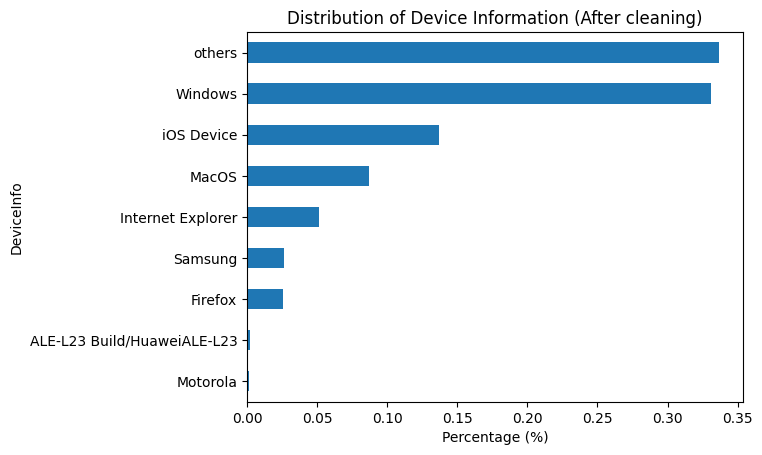

In [136]:
# plot the top 10
df_identity['DeviceInfo'].value_counts(normalize=True).sort_values().plot.barh()

# label the chart
plt.xlabel('Percentage (%)')
plt.title('Distribution of Device Information (After cleaning)');

In [137]:
df_identity.isna().sum()

TransactionID        0
id_01                0
id_02             3361
id_03            77909
id_04            77909
id_05             7368
id_06             7368
id_09            69307
id_10            69307
id_11             3255
id_12                0
id_13            16913
id_14            64189
id_15             3248
id_16            14893
id_17             4864
id_18            99120
id_19             4915
id_20             4972
id_28             3255
id_29             3255
id_30            66668
id_31             3951
id_32            66647
id_33            70944
id_34            66428
id_35             3248
id_36             3248
id_37             3248
id_38             3248
DeviceType           0
DeviceInfo           0
dtype: int64

In [138]:
id_categorical_cols = (
    [f"id_{i}" for i in range(12, 21)] + 
    [f"id_{i}" for i in range(28, 39)]
)

print(id_categorical_cols)

['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']


In [139]:
# Define categorical ID columns with missing values
id_categorical_cols = (
    [f"id_{i}" for i in range(12, 21)] + 
    [f"id_{i}" for i in range(28, 39)]
)

# Replace NaNs with "missing" in these columns
for col in id_categorical_cols:
    if col in df_identity.columns:  # safety check
        df_identity[col] = df_identity[col].fillna("missing")

print(df_identity.isna().sum())

TransactionID        0
id_01                0
id_02             3361
id_03            77909
id_04            77909
id_05             7368
id_06             7368
id_09            69307
id_10            69307
id_11             3255
id_12                0
id_13                0
id_14                0
id_15                0
id_16                0
id_17                0
id_18                0
id_19                0
id_20                0
id_28                0
id_29                0
id_30                0
id_31                0
id_32                0
id_33                0
id_34                0
id_35                0
id_36                0
id_37                0
id_38                0
DeviceType           0
DeviceInfo           0
dtype: int64


In [140]:
df_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 32 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_09          74926 non-null   float64
 8   id_10          74926 non-null   float64
 9   id_11          140978 non-null  float64
 10  id_12          144233 non-null  object 
 11  id_13          144233 non-null  object 
 12  id_14          144233 non-null  object 
 13  id_15          144233 non-null  object 
 14  id_16          144233 non-null  object 
 15  id_17          144233 non-null  object 
 16  id_18          144233 non-null  object 
 17  id_19          144233 non-nul

In [141]:
int_cols = ([f"id_0{i}" for i in range(2, 7)] +
            ["id_09", "id_10", "id_11"]
)
print(int_cols)

for col in int_cols:
    print('*' * 40)
    print(f"Min of {col}:", df_identity[col].min().round(4))
    print(f"Max of {col}:", df_identity[col].max().round(4))
    print(f"Mean of {col}:", df_identity[col].mean().round(4))
    print(f"Median of {col}:", df_identity[col].median().round(4))

['id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11']
****************************************
Min of id_02: 1.0
Max of id_02: 999595.0
Mean of id_02: 174716.5847
Median of id_02: 125800.5
****************************************
Min of id_03: -13.0
Max of id_03: 10.0
Mean of id_03: 0.0602
Median of id_03: 0.0
****************************************
Min of id_04: -28.0
Max of id_04: 0.0
Mean of id_04: -0.0589
Median of id_04: 0.0
****************************************
Min of id_05: -72.0
Max of id_05: 52.0
Mean of id_05: 1.6156
Median of id_05: 0.0
****************************************
Min of id_06: -100.0
Max of id_06: 0.0
Mean of id_06: -6.6987
Median of id_06: 0.0
****************************************
Min of id_09: -36.0
Max of id_09: 25.0
Mean of id_09: 0.091
Median of id_09: 0.0
****************************************
Min of id_10: -100.0
Max of id_10: 0.0
Mean of id_10: -0.3011
Median of id_10: 0.0
****************************************
Min of id_11

Looking at the distribution of the numerical identity features, we impute missing values with the `median` instead of `mean` because most o them are skewed.

In [142]:
# Impute the numerical features
for col in int_cols:
    col_median = df_identity[col].median()
    df_identity[col] = df_identity[col].fillna(col_median)

print(df_identity.isna().sum())

TransactionID    0
id_01            0
id_02            0
id_03            0
id_04            0
id_05            0
id_06            0
id_09            0
id_10            0
id_11            0
id_12            0
id_13            0
id_14            0
id_15            0
id_16            0
id_17            0
id_18            0
id_19            0
id_20            0
id_28            0
id_29            0
id_30            0
id_31            0
id_32            0
id_33            0
id_34            0
id_35            0
id_36            0
id_37            0
id_38            0
DeviceType       0
DeviceInfo       0
dtype: int64


In [143]:
# merge the 2 datasets
df_merged = df.merge(df_identity, on = 'TransactionID', how = 'left')

df_merged.shape

(590540, 58)

In [144]:
df.shape[0] - df_identity.shape[0]

446307

In [145]:
df_merged.isna().sum()

TransactionID           0
isFraud                 0
TransactionDT           0
TransactionAmt          0
ProductCD               0
card1                   0
card2                   0
card3                   0
card4                   0
card5                   0
card6                   0
addr1                   0
addr2                   0
dist1                   0
dist2                   0
D1                      0
D2                      0
D3                      0
D4                      0
D5                      0
D10                     0
D11                     0
D15                     0
billing_address         0
provider_bucket         0
fraud_bucket            0
suffix_bucket           0
id_01              446307
id_02              446307
id_03              446307
id_04              446307
id_05              446307
id_06              446307
id_09              446307
id_10              446307
id_11              446307
id_12              446307
id_13              446307
id_14       

The high level of missingness in identity features is not a flaw in the data but a structural property: identity information is only captured for ~25% of transactions. This missingness itself may contain valuable signals about fraud. Instead of dropping these features, we encode both the presence/absence of identity checks and the values when available, allowing the model to learn from the underlying patterns.

In [146]:
df_merged.groupby(df_merged['id_01'].isna())['isFraud'].mean()

id_01
False    0.078470
True     0.020939
Name: isFraud, dtype: float64

In [147]:
df_merged.groupby(df_merged['id_02'].isna())['isFraud'].mean()

id_02
False    0.078470
True     0.020939
Name: isFraud, dtype: float64

In [148]:
df_merged.groupby(df_merged['id_38'].isna())['isFraud'].mean()

id_38
False    0.078470
True     0.020939
Name: isFraud, dtype: float64

In [149]:
df_merged.groupby(df_merged['DeviceType'].isna())['isFraud'].mean()

DeviceType
False    0.078470
True     0.020939
Name: isFraud, dtype: float64

In [150]:
df_merged.groupby(df_merged['DeviceInfo'].isna())['isFraud'].mean()

DeviceInfo
False    0.078470
True     0.020939
Name: isFraud, dtype: float64

In [151]:
df_merged.isna().sum()

TransactionID           0
isFraud                 0
TransactionDT           0
TransactionAmt          0
ProductCD               0
card1                   0
card2                   0
card3                   0
card4                   0
card5                   0
card6                   0
addr1                   0
addr2                   0
dist1                   0
dist2                   0
D1                      0
D2                      0
D3                      0
D4                      0
D5                      0
D10                     0
D11                     0
D15                     0
billing_address         0
provider_bucket         0
fraud_bucket            0
suffix_bucket           0
id_01              446307
id_02              446307
id_03              446307
id_04              446307
id_05              446307
id_06              446307
id_09              446307
id_10              446307
id_11              446307
id_12              446307
id_13              446307
id_14       

For the identity dataset, we chose not to impute the missing values because their absence is itself meaningful — identity information such as device, browser, or network signatures may be deliberately hidden or unavailable in fraudulent cases. Instead, we retained the missing values and created binary indicator features `(e.g., id_01_missing)`, allowing the model to learn from both the presence and absence of this information. This approach preserves predictive signal while also improving explainability, since we can later interpret how missing identity attributes correlate with fraud.

In [153]:
# Select only id_* columns
id_cols = [col for col in df_merged.columns if col.startswith("id_")] + ['DeviceType', 'DeviceInfo']

# Create missingness indicator for each id_* column
for col in id_cols:
    df_merged[col + "_missing"] = df_merged[col].isna().astype(int)

# Quick check
df_merged[[col for col in df_merged.columns if col.endswith("_missing")]].head()

,id_01_missing,id_02_missing,id_03_missing,id_04_missing,id_05_missing,id_06_missing,id_09_missing,id_10_missing,id_11_missing,id_12_missing,...,id_31_missing,id_32_missing,id_33_missing,id_34_missing,id_35_missing,id_36_missing,id_37_missing,id_38_missing,DeviceType_missing,DeviceInfo_missing
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [155]:
print(df_merged.isna().sum())

TransactionID         0
isFraud               0
TransactionDT         0
TransactionAmt        0
ProductCD             0
                     ..
id_36_missing         0
id_37_missing         0
id_38_missing         0
DeviceType_missing    0
DeviceInfo_missing    0
Length: 89, dtype: int64


In [159]:
print(df_merged.columns)

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10',
       'D11', 'D15', 'billing_address', 'provider_bucket', 'fraud_bucket',
       'suffix_bucket', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_28', 'id_29', 'id_30', 'id_31',
       'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo', 'id_01_missing', 'id_02_missing',
       'id_03_missing', 'id_04_missing', 'id_05_missing', 'id_06_missing',
       'id_09_missing', 'id_10_missing', 'id_11_missing', 'id_12_missing',
       'id_13_missing', 'id_14_missing', 'id_15_missing', 'id_16_missing',
       'id_17_missing', 'id_18_missing', 'id_19_missing', 'id_20_missing',
       'id_28_missing', 'i

In [160]:
df_merged.shape

(590540, 89)

In [163]:
# save the cleaned dataset

import os
import time
import pandas as pd

# Ensure dataset folder exists
os.makedirs("dataset", exist_ok=True)

# Convert all object columns to string (prevents ArrowTypeError)
for col in df_merged.select_dtypes(include=["object"]).columns:
    df_merged[col] = df_merged[col].astype(str)

# --- Save in different formats ---
# CSV
csv_path = "dataset/cleaned_fraud_dataset.csv"
start = time.time()
df_merged.to_csv(csv_path, index=False)
csv_save_time = time.time() - start

# Parquet
parquet_path = "dataset/cleaned_fraud_dataset.parquet"
start = time.time()
df_merged.to_parquet(parquet_path, index=False)
parquet_save_time = time.time() - start

# --- File sizes ---
csv_size = os.path.getsize(csv_path) / (1024*1024)
parquet_size = os.path.getsize(parquet_path) / (1024*1024)

# --- Load times ---
start = time.time(); pd.read_csv(csv_path); csv_load_time = time.time() - start
start = time.time(); pd.read_parquet(parquet_path); parquet_load_time = time.time() - start

# --- Results ---
print(f"CSV    -> Size: {csv_size:.2f} MB | Save: {csv_save_time:.2f}s | Load: {csv_load_time:.2f}s")
print(f"Parquet-> Size: {parquet_size:.2f} MB | Save: {parquet_save_time:.2f}s | Load: {parquet_load_time:.2f}s")

C:\Users\NEW\AppData\Local\Temp\ipykernel_12324\3602027375.py:32: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  start = time.time(); pd.read_csv(csv_path); csv_load_time = time.time() - start


CSV    -> Size: 186.33 MB | Save: 8.46s | Load: 2.42s
Parquet-> Size: 25.05 MB | Save: 1.91s | Load: 0.61s
